ابتدا برخی مقدمات:

In [ ]:
#چون از گوگل کولب استفاده می‌کنیم و همچنین چون فایل‌های مرتبط با تمرین را از قبل در درایو گوگل ذخیره کرده بودیم، با کد زیر امکان دسترسی به درایو توسط کولب زا فراهم می‌کنیم.
from google.colab import drive
drive.mount('/content/drive')

#برای این تمرین از تابعی از کتابخانه‌ی زیر استفاده شده است. از آنجا که این کتابخانه به صورت پیشفرض در کولب نصب نشده، با دستور آتی آن را نصب می‌کنیم.
!pip install python-utils

#توابعی که ظراح محترم سوال جهت کمک به دانشجویان قرار دادند در مسیر زیر قرار دارند (هر مسیری می‌تواند باشد). این مسیر می‌بایست به مسیرهای پایتون اضافه گردد تا بتوان این توابع را به صورت کتابخانه به کد افزود.
import sys
sys.path.insert(0, '/content/drive/MyDrive/NN_HW3/Q2/Requied_Files')

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#کتابخانه‌های مورد نیاز جهت کد تمرین در ادامه فراخوانی می‌گردند.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from utils import collate_fn
from pascal_dataset import PASCALDataset
from engine import train_one_epoch, evaluate

#برای تمرین از پردازنده‌گرافیکی استفاده می‌کنیم.
device = torch.device('cuda')

<div dir='rtl'>
  سه دسته داده‌ی train، validation و test به صورت آتی خوانده‌ می‌شوند. تابع PASCALDataset در حقیقت کمک می‌کند که تصاویر دیتاست، مرزهای اشیاء مدنظر موجود در تصاویر و همچنین برچسب‌های اشیاء به صورت ساخت یافته خوانده شوند. میتوان آدرس مدنظر خود (آدرس دیتاست) را در متغیر dir جایگزین کرد.
</div>

In [ ]:
dir = '/content/drive/MyDrive/NN_HW3/Q2/PASCAL/PASCAL/'
train_dataset = PASCALDataset(dir + 'train')
validation_dataset = PASCALDataset(dir + 'val')
test_dataset = PASCALDataset(dir + 'test')

In [ ]:
def plotter(data, boxes, labels, scores = None, threshold = 0.6):  
  if scores is None:
    scores = np.ones(labels.shape)
  elif type(scores) == torch.Tensor:
    scores = scores.numpy()
  labels, indicies = labels.sort()  
  boxes = boxes[indicies]
  scores = scores[indicies]    
  label_color = {5:'red', 1:'green', 2:'blue', 3:'yellow', 4:'pink'}
  label_name = {5:'plane', 1:'person', 2:'bicycle', 3:'car', 4:'motor cycle'}
  plt.imshow(torch.permute(data, (1,2,0)))
  for idx, box in enumerate(boxes):
    if scores[idx] > threshold:
      plt.gca().add_patch(
                                Rectangle(
                                            (box[0],box[1]),box[2] - box[0],box[3] - box[1],
                                            edgecolor=label_color[labels[idx].item()],                  
                                            facecolor='none',
                                            lw=3                                          
                                          ),                               
                              )
      plt.annotate(xy=(box[0],box[1]),text = label_name[labels[idx].item()], bbox = dict(fc='white')) 
  #LEGENDS
  labels = labels[scores >= threshold]
  unique_labels = torch.unique(labels, return_counts=True)      
  legends = []
  for i in range(len(unique_labels[0])):
    legends.append(label_name[unique_labels[0][i].item()] + ': ' + str(unique_labels[1][i].item()))
    for j in range(unique_labels[1][i]-1):
      legends.append('_nolegend_')   
  warnings.filterwarnings("ignore")
  plt.legend(legends)
  warnings.filterwarnings('default')


plotter(train_dataset[988][0], train_dataset[988][1]['boxes'], train_dataset[988][1]['labels'])

دریافت و شخصی سازی مدل مدنظر سوال (+ معماری مدل):

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 6) #5 classes
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 221MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

تعریف آپتیمایزر و ضریب یادگیری. برای این دو مورد از پیشنهاد های موجود در صفحه کگل دیتاست کمک گرفته شد. البته با توجه به قدرت مدل می‌توانستیم مقادیر نزدیک به مقادیر زیر را نیز در نظر بگیریم و به همین نتیجه‌ی فعلی برسیم.

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

تعریف دیتالودرهای ساده

In [ ]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

validation_data_loader = DataLoader(
    validation_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

<div dir='rtl'>
  آموزش مدل به شیوه‌ی transform learning و به کمک توابع ارائه شده توسط طراح محترم سوال:
</div>

In [ ]:
epochs = 5
for epoch in range(epochs):    
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)    
    lr_scheduler.step()    
    evaluate(model, validation_data_loader, device=device)

    
torch.save(model.state_dict(), '/content/drive/MyDrive/NN_HW3/Q2/model2_backup.pth')

Epoch: [0]  [  0/251]  eta: 0:28:59  lr: 0.000025  loss: 2.2254 (2.2254)  loss_classifier: 1.6095 (1.6095)  loss_box_reg: 0.5881 (0.5881)  loss_objectness: 0.0124 (0.0124)  loss_rpn_box_reg: 0.0153 (0.0153)  time: 6.9316  data: 3.6558  max mem: 4454
Epoch: [0]  [ 10/251]  eta: 0:08:19  lr: 0.000225  loss: 1.8446 (1.9197)  loss_classifier: 1.5404 (1.5358)  loss_box_reg: 0.2510 (0.3525)  loss_objectness: 0.0109 (0.0101)  loss_rpn_box_reg: 0.0191 (0.0214)  time: 2.0740  data: 0.6680  max mem: 7485
Epoch: [0]  [ 20/251]  eta: 0:07:20  lr: 0.000425  loss: 1.7163 (1.7413)  loss_classifier: 1.4278 (1.3773)  loss_box_reg: 0.2510 (0.3372)  loss_objectness: 0.0073 (0.0102)  loss_rpn_box_reg: 0.0115 (0.0166)  time: 1.6567  data: 0.3960  max mem: 7485
Epoch: [0]  [ 30/251]  eta: 0:06:43  lr: 0.000624  loss: 1.3302 (1.5316)  loss_classifier: 0.9665 (1.1848)  loss_box_reg: 0.2719 (0.3212)  loss_objectness: 0.0056 (0.0092)  loss_rpn_box_reg: 0.0132 (0.0164)  time: 1.6897  data: 0.3839  max mem: 7485


In [ ]:
evaluate(model, test_data_loader, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:01:51  model_time: 2.0594 (2.0594)  evaluator_time: 0.0082 (0.0082)  time: 2.2220  data: 0.1488  max mem: 1935
Test:  [49/50]  eta: 0:00:00  model_time: 0.5257 (0.5581)  evaluator_time: 0.0053 (0.0067)  time: 0.5531  data: 0.0136  max mem: 2713
Test: Total time: 0:00:29 (0.5864 s / it)
Averaged stats: model_time: 0.5257 (0.5581)  evaluator_time: 0.0053 (0.0067)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=

بررسی مدل روی سه تصویر از مجوعه تست (ردیف بالا تصاویر با مرزها و برچسب‌های اصلی و رئیف پایین همان تصاویر با مرزها و برچسب‌های تخمین زده شده توسط مدل):

In [ ]:
def data_to_image(data):
    tmp = data[0].detach().clone()
    data[0] = data[2]
    data[2] = tmp
    del tmp
    img = torch.permute(data ,(1,2,0))
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    img = img.to(device)
    return img

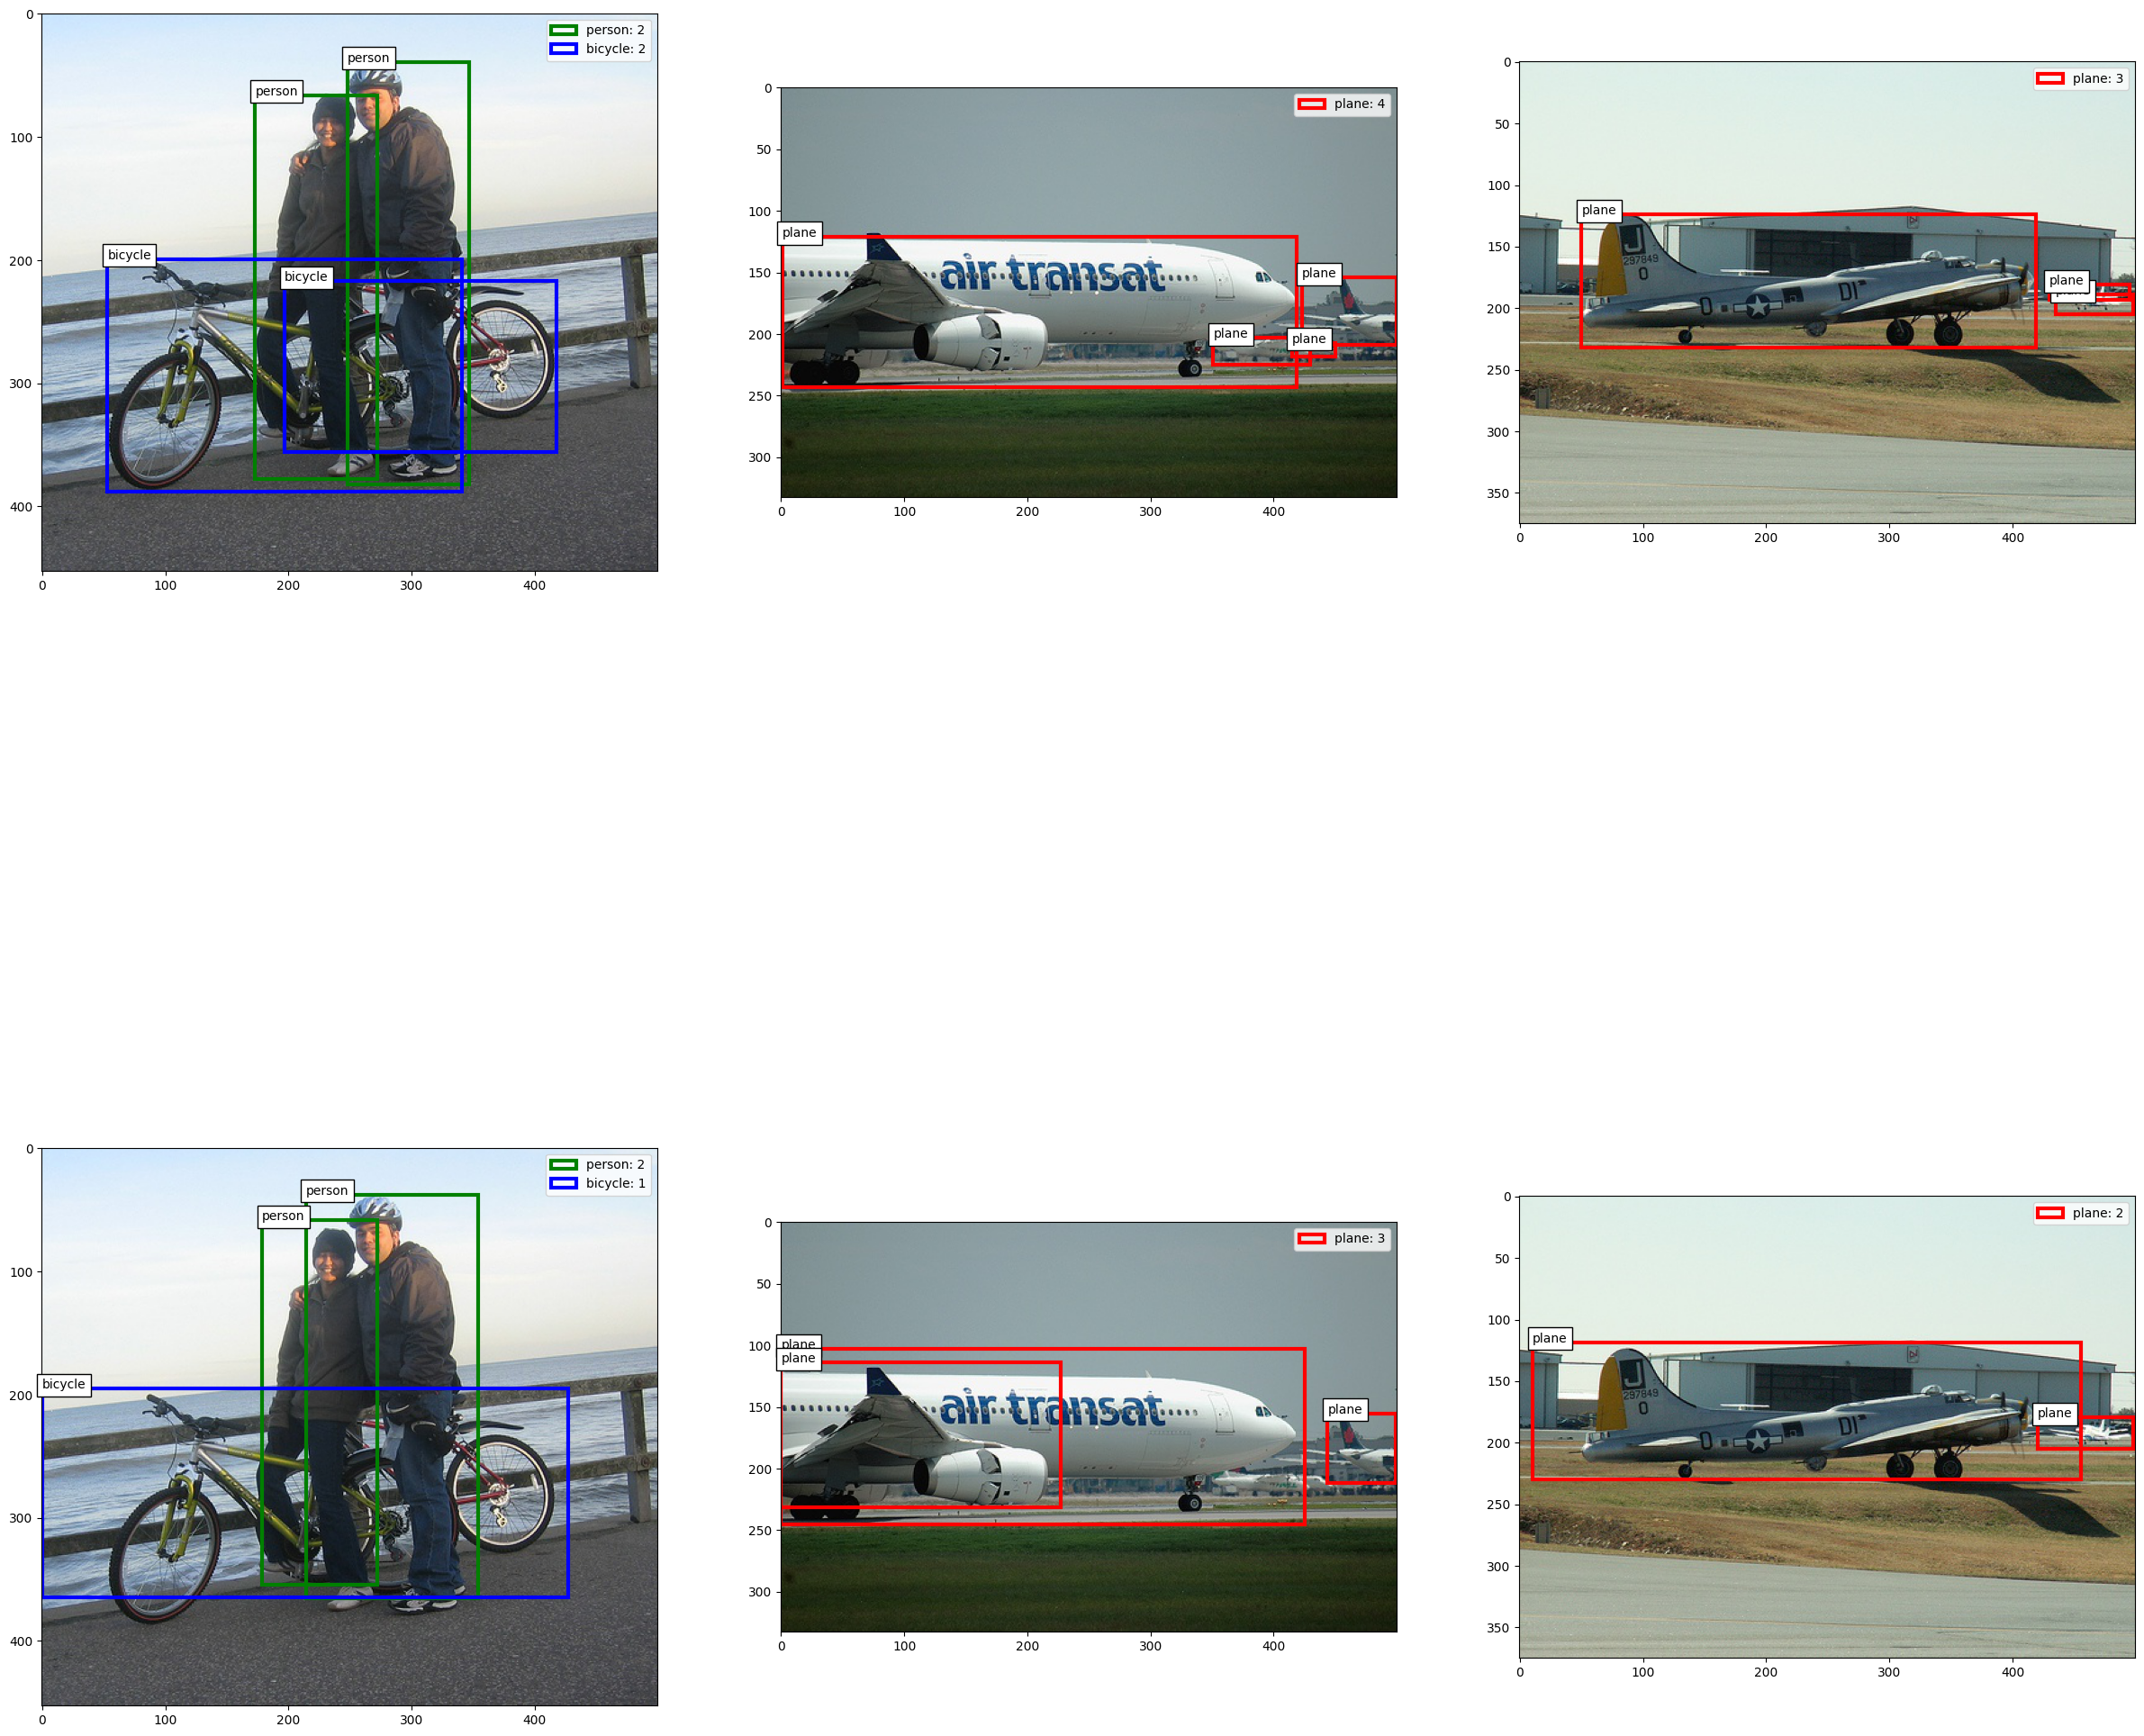

In [ ]:
fig = fig = plt.figure(figsize=(30, 30))
fig.add_subplot(2,3,1)
plotter(test_dataset[0][0], test_dataset[0][1]['boxes'], test_dataset[0][1]['labels'])
fig.add_subplot(2,3,2)
plotter(test_dataset[24][0], test_dataset[24][1]['boxes'], test_dataset[24][1]['labels'])
fig.add_subplot(2,3,3)
plotter(test_dataset[52][0], test_dataset[52][1]['boxes'], test_dataset[52][1]['labels'])

model.eval()
img = data_to_image(test_dataset[0][0])
fig.add_subplot(2,3,4)
plotter(test_dataset[0][0], model(img)[0]['boxes'].data.cpu(), model(img)[0]['labels'].data.cpu(), model(img)[0]['scores'].data.cpu(), 0.7)
img = data_to_image(test_dataset[24][0])
fig.add_subplot(2,3,5)
plotter(test_dataset[24][0], model(img)[0]['boxes'].data.cpu(), model(img)[0]['labels'].data.cpu(), model(img)[0]['scores'].data.cpu(), 0.7)
img = data_to_image(test_dataset[52][0])
fig.add_subplot(2,3,6)
plotter(test_dataset[52][0], model(img)[0]['boxes'].data.cpu(), model(img)[0]['labels'].data.cpu(), model(img)[0]['scores'].data.cpu(), 0.7)